<a href="https://colab.research.google.com/github/Danika-Balas/msds-458/blob/master/458_Assignment2_CNN_3x3nodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the following code we will set up both dense neural networks and convolutional neural networks to classify images of articles of clothing from the Fashion MNIST dataset into ten classes. We will set up five different experiments in order to explore the impact different nodes on the network and to determine what features in the images are detected by the nodes. 


Notebook uses portions of code written by Edward Arroyo and Daniel Jensen

##Setup and Preprocessing

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
keras.__version__

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.3.0-tf'

In [2]:
tf.__version__

'2.2.0-rc4'

In [3]:
from keras import metrics
from tensorflow.keras import models
from tensorflow.keras import layers

Using TensorFlow backend.


In [0]:
# neccessary for K.gradient to work in TensorFlow 2.x
# only needed for the "Finding a pattern the hidden node maximally responds to" section below.
# but disabled to make Tensorboard work...
tf.compat.v1.disable_eager_execution() 

In [0]:
# Set see in order to achieve consistent results across runs
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### Import Fashion-MNIST dataset

Using data from collected from European fasion platform Zalondo. The dataset has been compiled to mimic the structure of the MNIST dataset. It consists of 60,000 training images and 10,000 testing images. All of the images are in grayscale and 28x28 pixels. Each of the images is labeled with an integer 0-9 that corresponds to the following classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'.

More information can be found here: https://github.com/zalandoresearch/fashion-mnist 

In [6]:
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

4423680/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [7]:
#Store copy of training images in order to easily view images even after transformations are performed
example_train_images = train_images.copy()
example_train_images.shape

(60000, 28, 28)

In [8]:
# The distribution of the classes appears to be uniform
from collections import Counter
Counter(train_labels).most_common()

[(9, 6000),
 (0, 6000),
 (3, 6000),
 (2, 6000),
 (7, 6000),
 (5, 6000),
 (1, 6000),
 (6, 6000),
 (4, 6000),
 (8, 6000)]

In [0]:
# https://github.com/zalandoresearch/fashion-mnist
# https://www.tensorflow.org/tutorials/keras/classification

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Example of a single sample, a 28x28 pixel image of an article of clothing

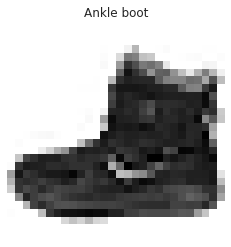

In [10]:
#https://matplotlib.org/tutorials/colors/colormaps.html?highlight=colormap
plt.imshow(train_images[0], cmap="binary") 
plt.axis('off')
plt.title(class_names[test_labels[0]], fontsize=12)
plt.show()

### Prepare the data


In [0]:
# Reshape the data into the shape that the network expects
train_images = train_images.reshape((60000, 28, 28, 1))

# Scale the data to [0,1] interval
train_images = train_images.astype('float32') / 255

# Do the same for the test dataset
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

Set aside 5,000 samples from the training data to use as the validation set.

In [0]:
val_images, train_images = train_images[:5000], train_images[5000:]
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

#Experiment 5 Baseline: 32, pool, 64, pool
Toying with conv dimensions


##Build and compile the model


In [13]:
# CNN with 2 convolution/max pooling layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
#keras.utils.plot_model(model, show_shapes=True)

### Create a callback to get training times

In [0]:
# Define callback to get total training time
import datetime

class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

##Train the model

In [16]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 5s 97us/sample - loss: 0.6038 - accuracy: 0.7780 - val_loss: 0.3779 - val_accuracy: 0.8682
Epoch 2/20
55000/55000 [==============================] - 5s 95us/sample - loss: 0.3932 - accuracy: 0.8555 - val_loss: 0.3147 - val_accuracy: 0.8848
Epoch 3/20
55000/55000 [==============================] - 5s 93us/sample - loss: 0.3404 - accuracy: 0.8740 - val_loss: 0.2906 - val_accuracy: 0.8978
Epoch 4/20
55000/55000 [==============================] - 5s 94us/sample - loss: 0.3090 - accuracy: 0.8851 - val_loss: 0.2641 - val_accuracy: 0.9040
Epoch 5/20
55000/55000 [==============================] - 5s 93us/sample - loss: 0.2830 - accuracy: 0.8949 - val_loss: 0.2462 - val_accuracy: 0.9112
Epoch 6/20
55000/55000 [==============================] - 5s 93us/sample - loss: 0.2652 - accuracy: 0.9016 - val_loss: 0.2516 - val_accuracy: 0.9108
Epoch 7/20
55000/55000 [==============================] -

In [17]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

115.624179

## Test the model

In [0]:
# Define callback to get total test time
import datetime

class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [19]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.2319909753680229, 0.9187)

In [20]:
test_time = test_rt.process_time
test_time # in seconds

0.844875

### Create a dataframe for the training and test statistics

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.170699,0.936036,0.216009,0.9230
16,0.164696,0.937055,0.219202,0.9244
17,0.159298,0.940127,0.218168,0.9222
18,0.152709,0.942309,0.224936,0.9212
19,0.150072,0.942018,0.219612,0.9260


In [23]:
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','CNN (2 layers), baseline 32pool64pool') # model name appears first
results_df['test_loss'] = test_loss #incorporate test results
results_df['test_accuracy'] = test_acc
results_df['training time (sec)'] = train_time    
results_df['testing time (sec)'] = test_time      # testing time appears last
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,"CNN (2 layers), baseline 32pool64pool",0.150072,0.942018,0.219612,0.926,0.231991,0.9187,115.624179,0.844875


### Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss/accuracy for each training epoch side by side.

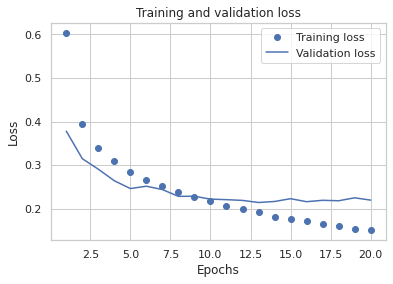

In [24]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

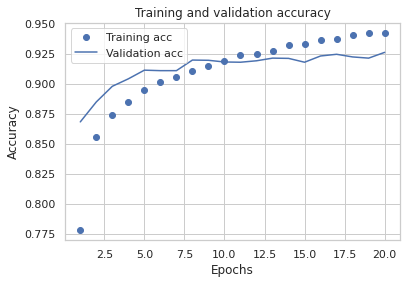

In [25]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 6
64, pool, 32, pool

##Build and compile the model

In [0]:
# CNN with 2 convolution/max pooling layers

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# keras.utils.plot_model(model, show_shapes=True)

##Train the model

In [28]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 4s 66us/sample - loss: 0.6192 - accuracy: 0.7690 - val_loss: 0.4077 - val_accuracy: 0.8526
Epoch 2/20
55000/55000 [==============================] - 4s 64us/sample - loss: 0.4010 - accuracy: 0.8525 - val_loss: 0.3229 - val_accuracy: 0.8828
Epoch 3/20
55000/55000 [==============================] - 4s 65us/sample - loss: 0.3451 - accuracy: 0.8728 - val_loss: 0.3014 - val_accuracy: 0.8912
Epoch 4/20
55000/55000 [==============================] - 4s 64us/sample - loss: 0.3152 - accuracy: 0.8829 - val_loss: 0.2764 - val_accuracy: 0.8954
Epoch 5/20
55000/55000 [==============================] - 4s 64us/sample - loss: 0.2942 - accuracy: 0.8920 - val_loss: 0.2636 - val_accuracy: 0.9020
Epoch 6/20
55000/55000 [==============================] - 4s 65us/sample - loss: 0.2745 - accuracy: 0.8983 - val_loss: 0.2752 - val_accuracy: 0.8972
Epoch 7/20
55000/55000 [==============================] -

In [29]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

71.097494

## Test the model

In [30]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.23763156986832618, 0.9165)

In [31]:
test_time = test_rt.process_time
test_time # in seconds

0.501577

##Add training and test statistics to results dataframe

In [32]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.185832,0.929164,0.224416,0.9186
16,0.179466,0.932127,0.214648,0.9190
17,0.178104,0.931891,0.213720,0.9204
18,0.171284,0.934655,0.208412,0.9222
19,0.165884,0.936509,0.212797,0.9248


In [33]:
results_dfnew = history_df.iloc[-1:].copy()
results_dfnew.insert(0,'model','CNN (2 layers), 64pool32pool') # want the model name to appear first
results_dfnew['test_loss'] = test_loss #incorporate test results
results_dfnew['test_accuracy'] = test_acc
results_dfnew['training time (sec)'] = train_time     
results_dfnew['testing time (sec)'] = test_time      # testing time appears last
results_dfnew

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,"CNN (2 layers), 64pool32pool",0.165884,0.936509,0.212797,0.9248,0.237632,0.9165,71.097494,0.501577


In [34]:
results_df=results_df.append(results_dfnew,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,"CNN (2 layers), baseline 32pool64pool",0.148440,0.942564,0.229695,0.9206,0.240504,0.9187,68.169618,0.486633
1,"CNN (2 layers), 64pool32pool",0.165884,0.936509,0.212797,0.9248,0.237632,0.9165,71.097494,0.501577


## Plotting the performance 

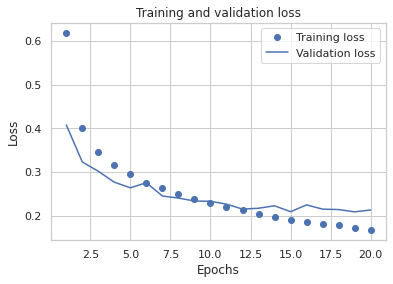

In [35]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

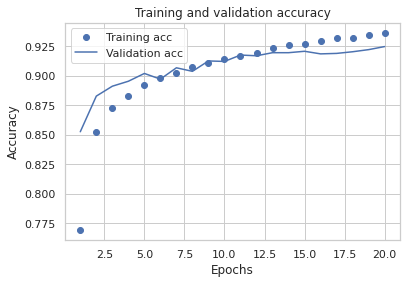

In [36]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [37]:
# save the model
model.save("experiment4")

INFO:tensorflow:Assets written to: experiment4/assets


#Experiment 7
32, 64, pool


##Build and compile the model

In [0]:
# CNN with 2 convolution/max pooling layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# keras.utils.plot_model(model, show_shapes=True)

##Train the model

In [39]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 6s 115us/sample - loss: 0.4610 - accuracy: 0.8333 - val_loss: 0.3074 - val_accuracy: 0.8880
Epoch 2/20
55000/55000 [==============================] - 6s 112us/sample - loss: 0.2922 - accuracy: 0.8937 - val_loss: 0.2537 - val_accuracy: 0.9062
Epoch 3/20
55000/55000 [==============================] - 6s 113us/sample - loss: 0.2426 - accuracy: 0.9115 - val_loss: 0.2237 - val_accuracy: 0.9162
Epoch 4/20
55000/55000 [==============================] - 6s 114us/sample - loss: 0.2083 - accuracy: 0.9226 - val_loss: 0.2156 - val_accuracy: 0.9226
Epoch 5/20
55000/55000 [==============================] - 6s 112us/sample - loss: 0.1800 - accuracy: 0.9331 - val_loss: 0.2094 - val_accuracy: 0.9236
Epoch 6/20
55000/55000 [==============================] - 6s 112us/sample - loss: 0.1562 - accuracy: 0.9427 - val_loss: 0.2098 - val_accuracy: 0.9230
Epoch 7/20
55000/55000 [===========================

In [40]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

124.336392

## Test the model

In [41]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.3386828497685492, 0.9218)

In [42]:
test_time = test_rt.process_time
test_time # in seconds

0.570556

##Add training and test statistics to results dataframe

In [43]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.045725,0.982855,0.275304,0.9288
16,0.044769,0.983236,0.297501,0.9284
17,0.042122,0.984636,0.311545,0.9312
18,0.040645,0.985600,0.317275,0.9300
19,0.037664,0.986400,0.302862,0.9294


In [44]:
results_dfnew = history_df.iloc[-1:].copy()
results_dfnew.insert(0,'model','CNN (2 layers), 32-64-pool2') # want the model name to appear first
results_dfnew['test_loss'] = test_loss #incorporate test results
results_dfnew['test_accuracy'] = test_acc
results_dfnew['training time (sec)'] = train_time     
results_dfnew['testing time (sec)'] = test_time      # testing time appears last
results_dfnew

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,"CNN (2 layers), 32-64-pool2",0.037664,0.9864,0.302862,0.9294,0.338683,0.9218,124.336392,0.570556


In [45]:
results_df=results_df.append(results_dfnew,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,"CNN (2 layers), baseline 32pool64pool",0.148455,0.943418,0.216722,0.9288,0.236925,0.9185,68.474213,0.473921
1,"CNN (2 layers), 32-64-pool",0.033827,0.987745,0.307374,0.9304,0.344505,0.9281,123.952591,0.554755
2,"CNN (2 layers), 32-64-pool2",0.037664,0.986400,0.302862,0.9294,0.338683,0.9218,124.336392,0.570556


## Plotting the performance 

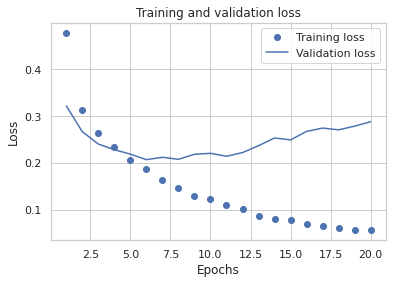

In [47]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

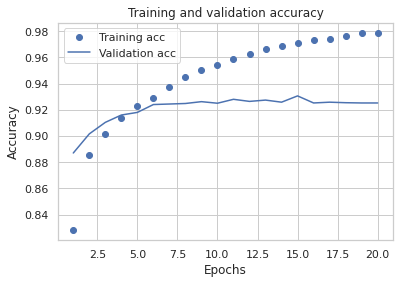

In [48]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 8 
4 layer CNN: 32, 32, pool, 64, 64, pool


##Build and compile the model

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# keras.utils.plot_model(model, show_shapes=True)

In [41]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
dropout_16 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
dropout_18 (Dropout)         (None, 10, 10, 64)       

##Train the model

In [28]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 12s 226us/sample - loss: 0.6319 - accuracy: 0.7604 - val_loss: 0.4088 - val_accuracy: 0.8486
Epoch 2/20
55000/55000 [==============================] - 12s 219us/sample - loss: 0.3969 - accuracy: 0.8528 - val_loss: 0.3074 - val_accuracy: 0.8888
Epoch 3/20
55000/55000 [==============================] - 12s 220us/sample - loss: 0.3308 - accuracy: 0.8776 - val_loss: 0.2654 - val_accuracy: 0.9014
Epoch 4/20
55000/55000 [==============================] - 12s 221us/sample - loss: 0.2957 - accuracy: 0.8912 - val_loss: 0.2580 - val_accuracy: 0.9012
Epoch 5/20
55000/55000 [==============================] - 12s 220us/sample - loss: 0.2745 - accuracy: 0.8978 - val_loss: 0.2501 - val_accuracy: 0.9060
Epoch 6/20
55000/55000 [==============================] - 12s 221us/sample - loss: 0.2575 - accuracy: 0.9054 - val_loss: 0.2313 - val_accuracy: 0.9150
Epoch 7/20
55000/55000 [=====================

In [29]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

243.798351

## Test the model

In [30]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.22181144415140153, 0.9242)

In [31]:
test_time = test_rt.process_time
test_time # in seconds

1.056956

##Add training and test statistics to results dataframe

In [32]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.177916,0.932945,0.206743,0.9224
16,0.171240,0.935000,0.208062,0.9230
17,0.169073,0.936345,0.199012,0.9270
18,0.165332,0.937291,0.202852,0.9240
19,0.162009,0.939345,0.197643,0.9242


In [33]:
results_dfnew = history_df.iloc[-1:].copy()
results_dfnew.insert(0,'model','CNN (4 layers), 32-32pool-64-64pool') # want the model name to appear first
results_dfnew['test_loss'] = test_loss #incorporate test results
results_dfnew['test_accuracy'] = test_acc
results_dfnew['training time (sec)'] = train_time     
results_dfnew['testing time (sec)'] = test_time      # testing time appears last
results_dfnew

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,"CNN (4 layers), 32-32pool-64-64pool",0.162009,0.939345,0.197643,0.9242,0.221811,0.9242,243.798351,1.056956


In [34]:
results_df=results_df.append(results_dfnew,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,"CNN (2 layers), baseline 32pool64pool",0.150072,0.942018,0.219612,0.9260,0.231991,0.9187,115.624179,0.844875
1,"CNN (4 layers), 32-32pool-64-64pool",0.162009,0.939345,0.197643,0.9242,0.221811,0.9242,243.798351,1.056956


## Plotting the performance 

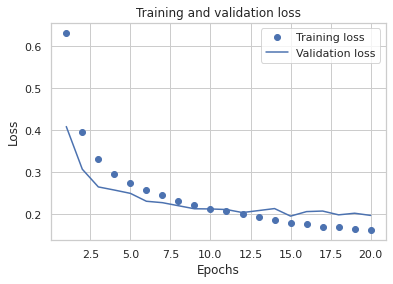

In [35]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

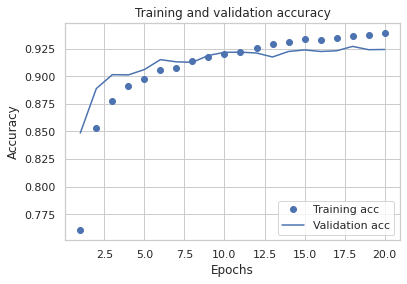

In [36]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 8b 
4 layer CNN: 32, pool, 32, pool, 64, pool, 64, pool


##Build and compile the model

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# keras.utils.plot_model(model, show_shapes=True)

In [69]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
dropout_34 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
dropout_35 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
dropout_36 (Dropout)         (None, 22, 22, 64)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 11, 11, 64)       

##Train the model

In [70]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 22s 395us/sample - loss: 0.5943 - accuracy: 0.7801 - val_loss: 0.4003 - val_accuracy: 0.8626
Epoch 2/20
55000/55000 [==============================] - 21s 389us/sample - loss: 0.3604 - accuracy: 0.8676 - val_loss: 0.3079 - val_accuracy: 0.8958
Epoch 3/20
55000/55000 [==============================] - 21s 388us/sample - loss: 0.3047 - accuracy: 0.8881 - val_loss: 0.2958 - val_accuracy: 0.8956
Epoch 4/20
55000/55000 [==============================] - 21s 387us/sample - loss: 0.2787 - accuracy: 0.8974 - val_loss: 0.2490 - val_accuracy: 0.9060
Epoch 5/20
55000/55000 [==============================] - 21s 386us/sample - loss: 0.2548 - accuracy: 0.9059 - val_loss: 0.2597 - val_accuracy: 0.9094
Epoch 6/20
55000/55000 [==============================] - 21s 387us/sample - loss: 0.2381 - accuracy: 0.9122 - val_loss: 0.2399 - val_accuracy: 0.9142
Epoch 7/20
55000/55000 [=====================

In [71]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

427.432288

## Test the model

In [72]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.2368437569975853, 0.9183)

In [73]:
test_time = test_rt.process_time
test_time # in seconds

1.216509

##Add training and test statistics to results dataframe

In [74]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.150796,0.942200,0.198722,0.9246
16,0.143369,0.944945,0.213594,0.9206
17,0.140380,0.947473,0.210054,0.9206
18,0.131233,0.949400,0.205022,0.9268
19,0.124191,0.953927,0.218363,0.9206


In [75]:
results_dfnew = history_df.iloc[-1:].copy()
results_dfnew.insert(0,'model','CNN (4 layers), 32-32-64pool-64pool') # want the model name to appear first
results_dfnew['test_loss'] = test_loss #incorporate test results
results_dfnew['test_accuracy'] = test_acc
results_dfnew['training time (sec)'] = train_time     
results_dfnew['testing time (sec)'] = test_time      # testing time appears last
results_dfnew

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,"CNN (4 layers), 32-32-64pool-64pool",0.124191,0.953927,0.218363,0.9206,0.236844,0.9183,427.432288,1.216509


In [76]:
results_df=results_df.append(results_dfnew,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,"CNN (2 layers), baseline 32pool64pool",0.150072,0.942018,0.219612,0.9260,0.231991,0.9187,115.624179,0.844875
1,"CNN (4 layers), 32-32pool-64-64pool",0.162009,0.939345,0.197643,0.9242,0.221811,0.9242,243.798351,1.056956
2,"CNN (4 layers), 32poolpool-32pool-64-64",0.258497,0.903400,0.228503,0.9142,0.254124,0.9081,116.579235,0.919488
3,"CNN (4 layers), 32pool-32pool-64-64",0.258497,0.903400,0.228503,0.9142,0.254124,0.9081,116.579235,0.919488
4,"CNN (4 layers), 32-32pool-64pool-64",0.172224,0.934891,0.198186,0.9212,0.222971,0.9199,231.822903,0.991374
5,"CNN (4 layers), 32-32-64pool-64pool",0.124191,0.953927,0.218363,0.9206,0.236844,0.9183,427.432288,1.216509


## Plotting the performance 

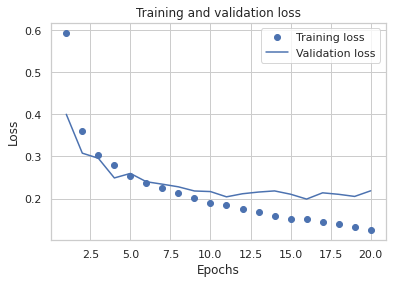

In [77]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

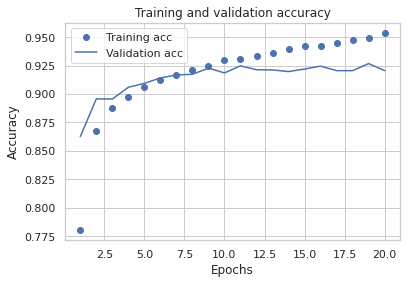

In [78]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 9
64, pool, 128, pool

##Build and compile the model

In [0]:
# CNN with 2 convolution/max pooling layers

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# keras.utils.plot_model(model, show_shapes=True)

##Train the model

In [63]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 4s 81us/sample - loss: 0.5217 - accuracy: 0.8091 - val_loss: 0.3351 - val_accuracy: 0.8808
Epoch 2/20
55000/55000 [==============================] - 4s 77us/sample - loss: 0.3384 - accuracy: 0.8757 - val_loss: 0.2792 - val_accuracy: 0.8994
Epoch 3/20
55000/55000 [==============================] - 4s 77us/sample - loss: 0.2911 - accuracy: 0.8926 - val_loss: 0.2628 - val_accuracy: 0.8990
Epoch 4/20
55000/55000 [==============================] - 4s 77us/sample - loss: 0.2606 - accuracy: 0.9035 - val_loss: 0.2590 - val_accuracy: 0.9008
Epoch 5/20
55000/55000 [==============================] - 4s 77us/sample - loss: 0.2416 - accuracy: 0.9102 - val_loss: 0.2246 - val_accuracy: 0.9164
Epoch 6/20
55000/55000 [==============================] - 4s 76us/sample - loss: 0.2211 - accuracy: 0.9183 - val_loss: 0.2207 - val_accuracy: 0.9196
Epoch 7/20
55000/55000 [==============================] -

In [64]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

85.164486

## Test the model

In [65]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.26855262257754803, 0.9209)

In [66]:
test_time = test_rt.process_time
test_time # in seconds

0.56504

##Add training and test statistics to results dataframe

In [67]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.116271,0.955545,0.220752,0.9242
16,0.112310,0.957091,0.234359,0.9216
17,0.104940,0.959145,0.231364,0.9258
18,0.097229,0.962382,0.217148,0.9286
19,0.095781,0.962927,0.242315,0.9218


In [68]:
results_dfnew = history_df.iloc[-1:].copy()
results_dfnew.insert(0,'model','CNN (2 layers), 64pool128pool') # want the model name to appear first
results_dfnew['test_loss'] = test_loss #incorporate test results
results_dfnew['test_accuracy'] = test_acc
results_dfnew['training time (sec)'] = train_time     
results_dfnew['testing time (sec)'] = test_time      # testing time appears last
results_dfnew

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,"CNN (2 layers), 64pool128pool",0.095781,0.962927,0.242315,0.9218,0.268553,0.9209,85.164486,0.56504


In [69]:
results_df=results_df.append(results_dfnew,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,"CNN (2 layers), baseline 32pool64pool",0.148440,0.942564,0.229695,0.9206,0.240504,0.9187,68.169618,0.486633
1,"CNN (2 layers), 64pool32pool",0.165884,0.936509,0.212797,0.9248,0.237632,0.9165,71.097494,0.501577
2,"CNN (2 layers), 32-64-pool, 5x5, 3x3",0.056374,0.978818,0.288349,0.9252,0.309188,0.9230,113.877381,0.559199
3,"CNN (4 layers), 32-32pool-64-64pool",0.149929,0.943709,0.213560,0.9236,0.234258,0.9245,128.761204,0.582940
4,"CNN (2 layers), 64pool128pool",0.095781,0.962927,0.242315,0.9218,0.268553,0.9209,85.164486,0.565040


## Plotting the performance 

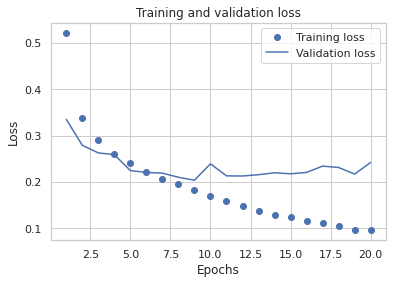

In [70]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

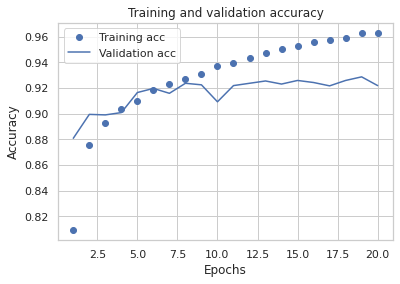

In [71]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [72]:
# save the model
model.save("experiment4")

INFO:tensorflow:Assets written to: experiment4/assets


#Experiment 10
4 layer CNN: 64, 64, pool, 128, 128, pool


##Build and compile the model

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# keras.utils.plot_model(model, show_shapes=True)

##Train the model

In [75]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 12s 210us/sample - loss: 0.5783 - accuracy: 0.7833 - val_loss: 0.3295 - val_accuracy: 0.8786
Epoch 2/20
55000/55000 [==============================] - 11s 207us/sample - loss: 0.3416 - accuracy: 0.8740 - val_loss: 0.2883 - val_accuracy: 0.8986
Epoch 3/20
55000/55000 [==============================] - 11s 205us/sample - loss: 0.2853 - accuracy: 0.8944 - val_loss: 0.2426 - val_accuracy: 0.9094
Epoch 4/20
55000/55000 [==============================] - 11s 205us/sample - loss: 0.2589 - accuracy: 0.9028 - val_loss: 0.2231 - val_accuracy: 0.9160
Epoch 5/20
55000/55000 [==============================] - 11s 206us/sample - loss: 0.2378 - accuracy: 0.9114 - val_loss: 0.2294 - val_accuracy: 0.9158
Epoch 6/20
55000/55000 [==============================] - 11s 205us/sample - loss: 0.2200 - accuracy: 0.9188 - val_loss: 0.2128 - val_accuracy: 0.9190
Epoch 7/20
55000/55000 [=====================

In [76]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

226.995776

## Test the model

In [77]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.2432280492171645, 0.9265)

In [78]:
test_time = test_rt.process_time
test_time # in seconds

0.667235

##Add training and test statistics to results dataframe

In [79]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.129122,0.951036,0.197779,0.9314
16,0.124039,0.953727,0.199424,0.9308
17,0.119188,0.954400,0.199098,0.9310
18,0.114459,0.955891,0.206939,0.9318
19,0.110739,0.957727,0.194529,0.9342


In [80]:
results_dfnew = history_df.iloc[-1:].copy()
results_dfnew.insert(0,'model','CNN (4 layers), 64-64pool-128-128pool') # want the model name to appear first
results_dfnew['test_loss'] = test_loss #incorporate test results
results_dfnew['test_accuracy'] = test_acc
results_dfnew['training time (sec)'] = train_time     
results_dfnew['testing time (sec)'] = test_time      # testing time appears last
results_dfnew

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,"CNN (4 layers), 64-64pool-128-128pool",0.110739,0.957727,0.194529,0.9342,0.243228,0.9265,226.995776,0.667235


In [81]:
results_df=results_df.append(results_dfnew,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,"CNN (2 layers), baseline 32pool64pool",0.148440,0.942564,0.229695,0.9206,0.240504,0.9187,68.169618,0.486633
1,"CNN (2 layers), 64pool32pool",0.165884,0.936509,0.212797,0.9248,0.237632,0.9165,71.097494,0.501577
2,"CNN (2 layers), 32-64-pool, 5x5, 3x3",0.056374,0.978818,0.288349,0.9252,0.309188,0.9230,113.877381,0.559199
3,"CNN (4 layers), 32-32pool-64-64pool",0.149929,0.943709,0.213560,0.9236,0.234258,0.9245,128.761204,0.582940
4,"CNN (2 layers), 64pool128pool",0.095781,0.962927,0.242315,0.9218,0.268553,0.9209,85.164486,0.565040
5,"CNN (4 layers), 64-64pool-128-128pool",0.110739,0.957727,0.194529,0.9342,0.243228,0.9265,226.995776,0.667235


## Plotting the performance 

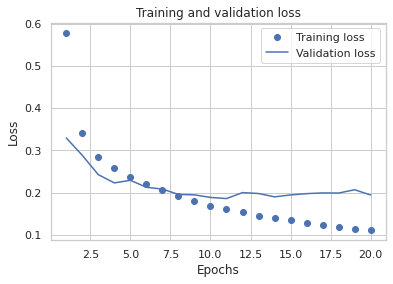

In [82]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

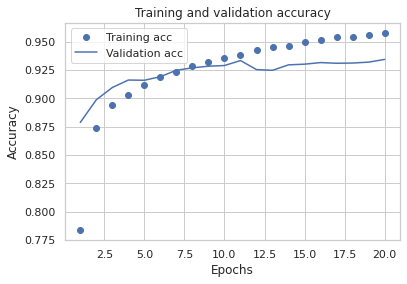

In [83]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 11
6 layer CNN: 64, 64, pool, 32, 32, pool


##Build and compile the model

In [0]:
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# keras.utils.plot_model(model, show_shapes=True)

##Train the model

In [86]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 10s 184us/sample - loss: 0.6542 - accuracy: 0.7542 - val_loss: 0.3755 - val_accuracy: 0.8664
Epoch 2/20
55000/55000 [==============================] - 10s 178us/sample - loss: 0.4064 - accuracy: 0.8490 - val_loss: 0.3159 - val_accuracy: 0.8834
Epoch 3/20
55000/55000 [==============================] - 10s 178us/sample - loss: 0.3435 - accuracy: 0.8724 - val_loss: 0.2760 - val_accuracy: 0.8972
Epoch 4/20
55000/55000 [==============================] - 10s 178us/sample - loss: 0.3150 - accuracy: 0.8829 - val_loss: 0.2610 - val_accuracy: 0.9002
Epoch 5/20
55000/55000 [==============================] - 10s 178us/sample - loss: 0.2935 - accuracy: 0.8931 - val_loss: 0.2450 - val_accuracy: 0.9094
Epoch 6/20
55000/55000 [==============================] - 10s 179us/sample - loss: 0.2776 - accuracy: 0.8965 - val_loss: 0.2373 - val_accuracy: 0.9098
Epoch 7/20
55000/55000 [=====================

In [87]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

197.533521

## Test the model

In [88]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.22332618759274483, 0.9191)

In [89]:
test_time = test_rt.process_time
test_time # in seconds

0.621062

##Add training and test statistics to results dataframe

In [90]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.205545,0.922273,0.200881,0.9222
16,0.202409,0.924491,0.196699,0.9262
17,0.195863,0.927491,0.205175,0.9188
18,0.195326,0.926491,0.199331,0.9238
19,0.190692,0.927491,0.196606,0.9240


In [91]:
results_dfnew = history_df.iloc[-1:].copy()
results_dfnew.insert(0,'model','CNN (4 layers), 64-64pool-32-32-pool') # want the model name to appear first
results_dfnew['test_loss'] = test_loss #incorporate test results
results_dfnew['test_accuracy'] = test_acc
results_dfnew['training time (sec)'] = train_time     
results_dfnew['testing time (sec)'] = test_time      # testing time appears last
results_dfnew

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,"CNN (4 layers), 64-64pool-32-32-pool",0.190692,0.927491,0.196606,0.924,0.223326,0.9191,197.533521,0.621062


In [92]:
results_df=results_df.append(results_dfnew,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,"CNN (2 layers), baseline 32pool64pool",0.148440,0.942564,0.229695,0.9206,0.240504,0.9187,68.169618,0.486633
1,"CNN (2 layers), 64pool32pool",0.165884,0.936509,0.212797,0.9248,0.237632,0.9165,71.097494,0.501577
2,"CNN (2 layers), 32-64-pool, 5x5, 3x3",0.056374,0.978818,0.288349,0.9252,0.309188,0.9230,113.877381,0.559199
3,"CNN (4 layers), 32-32pool-64-64pool",0.149929,0.943709,0.213560,0.9236,0.234258,0.9245,128.761204,0.582940
4,"CNN (2 layers), 64pool128pool",0.095781,0.962927,0.242315,0.9218,0.268553,0.9209,85.164486,0.565040
5,"CNN (4 layers), 64-64pool-128-128pool",0.110739,0.957727,0.194529,0.9342,0.243228,0.9265,226.995776,0.667235
6,"CNN (4 layers), 64-64pool-32-32-pool",0.190692,0.927491,0.196606,0.9240,0.223326,0.9191,197.533521,0.621062


## Plotting the performance 

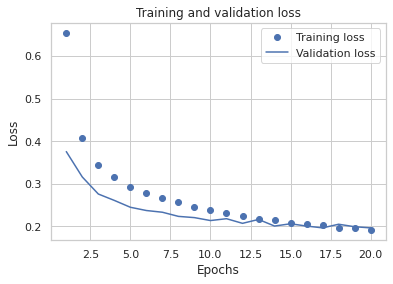

In [93]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

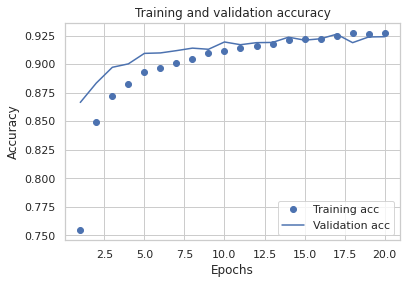

In [94]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 12 
4 layer CNN: 128, 128, pool, 64, 64, pool


##Build and compile the model

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# keras.utils.plot_model(model, show_shapes=True)

##Train the model

In [97]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 18s 334us/sample - loss: 0.5710 - accuracy: 0.7867 - val_loss: 0.3447 - val_accuracy: 0.8768
Epoch 2/20
55000/55000 [==============================] - 18s 328us/sample - loss: 0.3408 - accuracy: 0.8753 - val_loss: 0.2718 - val_accuracy: 0.8996
Epoch 3/20
55000/55000 [==============================] - 18s 327us/sample - loss: 0.2901 - accuracy: 0.8927 - val_loss: 0.2393 - val_accuracy: 0.9126
Epoch 4/20
55000/55000 [==============================] - 18s 327us/sample - loss: 0.2656 - accuracy: 0.9024 - val_loss: 0.2282 - val_accuracy: 0.9166
Epoch 5/20
55000/55000 [==============================] - 18s 327us/sample - loss: 0.2468 - accuracy: 0.9095 - val_loss: 0.2171 - val_accuracy: 0.9170
Epoch 6/20
55000/55000 [==============================] - 18s 327us/sample - loss: 0.2304 - accuracy: 0.9157 - val_loss: 0.2142 - val_accuracy: 0.9182
Epoch 7/20
55000/55000 [=====================

In [98]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

361.905492

## Test the model

In [99]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.21988401926457882, 0.9291)

In [100]:
test_time = test_rt.process_time
test_time # in seconds

0.780554

##Add training and test statistics to results dataframe

In [101]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.154309,0.940345,0.188002,0.9314
16,0.147668,0.944927,0.184828,0.9314
17,0.140275,0.947291,0.196094,0.9272
18,0.137737,0.948636,0.215701,0.9214
19,0.135746,0.948909,0.199482,0.9342


In [102]:
results_dfnew = history_df.iloc[-1:].copy()
results_dfnew.insert(0,'model','CNN (4 layers), 128-128pool-64-64pool') # want the model name to appear first
results_dfnew['test_loss'] = test_loss #incorporate test results
results_dfnew['test_accuracy'] = test_acc
results_dfnew['training time (sec)'] = train_time     
results_dfnew['testing time (sec)'] = test_time      # testing time appears last
results_dfnew

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,"CNN (4 layers), 128-128pool-64-64pool",0.135746,0.948909,0.199482,0.9342,0.219884,0.9291,361.905492,0.780554


In [103]:
results_df=results_df.append(results_dfnew,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,"CNN (2 layers), baseline 32pool64pool",0.148440,0.942564,0.229695,0.9206,0.240504,0.9187,68.169618,0.486633
1,"CNN (2 layers), 64pool32pool",0.165884,0.936509,0.212797,0.9248,0.237632,0.9165,71.097494,0.501577
2,"CNN (2 layers), 32-64-pool, 5x5, 3x3",0.056374,0.978818,0.288349,0.9252,0.309188,0.9230,113.877381,0.559199
3,"CNN (4 layers), 32-32pool-64-64pool",0.149929,0.943709,0.213560,0.9236,0.234258,0.9245,128.761204,0.582940
4,"CNN (2 layers), 64pool128pool",0.095781,0.962927,0.242315,0.9218,0.268553,0.9209,85.164486,0.565040
5,"CNN (4 layers), 64-64pool-128-128pool",0.110739,0.957727,0.194529,0.9342,0.243228,0.9265,226.995776,0.667235
6,"CNN (4 layers), 64-64pool-32-32-pool",0.190692,0.927491,0.196606,0.9240,0.223326,0.9191,197.533521,0.621062
7,"CNN (4 layers), 128-128pool-64-64pool",0.135746,0.948909,0.199482,0.9342,0.219884,0.9291,361.905492,0.780554


## Plotting the performance 

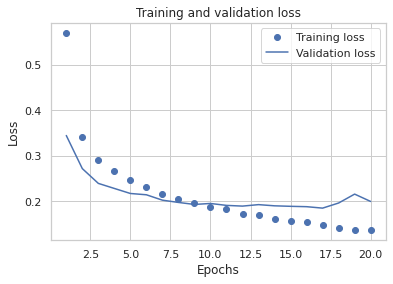

In [104]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

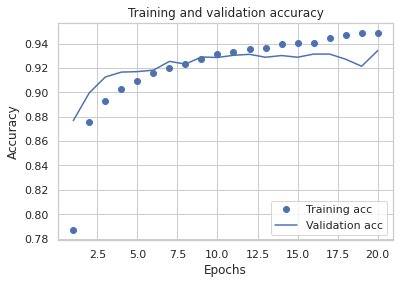

In [105]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 13
32 (5x5), 64 (3x3), pool


##Build and compile the model

In [0]:
# CNN with 2 convolution/max pooling layers

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# keras.utils.plot_model(model, show_shapes=True)

##Train the model

In [108]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 6s 112us/sample - loss: 0.4939 - accuracy: 0.8197 - val_loss: 0.3223 - val_accuracy: 0.8860
Epoch 2/20
55000/55000 [==============================] - 6s 105us/sample - loss: 0.3155 - accuracy: 0.8850 - val_loss: 0.2807 - val_accuracy: 0.9004
Epoch 3/20
55000/55000 [==============================] - 6s 105us/sample - loss: 0.2674 - accuracy: 0.9010 - val_loss: 0.2460 - val_accuracy: 0.9076
Epoch 4/20
55000/55000 [==============================] - 6s 105us/sample - loss: 0.2335 - accuracy: 0.9135 - val_loss: 0.2309 - val_accuracy: 0.9148
Epoch 5/20
55000/55000 [==============================] - 6s 105us/sample - loss: 0.2077 - accuracy: 0.9221 - val_loss: 0.2267 - val_accuracy: 0.9200
Epoch 6/20
55000/55000 [==============================] - 6s 104us/sample - loss: 0.1875 - accuracy: 0.9292 - val_loss: 0.2079 - val_accuracy: 0.9216
Epoch 7/20
55000/55000 [===========================

In [109]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

116.663987

## Test the model

In [110]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.3220721814654767, 0.9222)

In [111]:
test_time = test_rt.process_time
test_time # in seconds

0.565231

##Add training and test statistics to results dataframe

In [112]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.068713,0.974382,0.256795,0.9280
16,0.065885,0.975545,0.262751,0.9310
17,0.060932,0.977291,0.284940,0.9264
18,0.057802,0.978400,0.272332,0.9280
19,0.055121,0.979273,0.270570,0.9280


In [113]:
results_dfnew = history_df.iloc[-1:].copy()
results_dfnew.insert(0,'model','CNN (2 layers), 32-64-pool, 5x5, 3x3') # want the model name to appear first
results_dfnew['test_loss'] = test_loss #incorporate test results
results_dfnew['test_accuracy'] = test_acc
results_dfnew['training time (sec)'] = train_time     
results_dfnew['testing time (sec)'] = test_time      # testing time appears last
results_dfnew

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,"CNN (2 layers), 32-64-pool, 5x5, 3x3",0.055121,0.979273,0.27057,0.928,0.322072,0.9222,116.663987,0.565231


In [114]:
results_df=results_df.append(results_dfnew,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,"CNN (2 layers), baseline 32pool64pool",0.148440,0.942564,0.229695,0.9206,0.240504,0.9187,68.169618,0.486633
1,"CNN (2 layers), 64pool32pool",0.165884,0.936509,0.212797,0.9248,0.237632,0.9165,71.097494,0.501577
2,"CNN (2 layers), 32-64-pool, 5x5, 3x3",0.056374,0.978818,0.288349,0.9252,0.309188,0.9230,113.877381,0.559199
3,"CNN (4 layers), 32-32pool-64-64pool",0.149929,0.943709,0.213560,0.9236,0.234258,0.9245,128.761204,0.582940
4,"CNN (2 layers), 64pool128pool",0.095781,0.962927,0.242315,0.9218,0.268553,0.9209,85.164486,0.565040
5,"CNN (4 layers), 64-64pool-128-128pool",0.110739,0.957727,0.194529,0.9342,0.243228,0.9265,226.995776,0.667235
6,"CNN (4 layers), 64-64pool-32-32-pool",0.190692,0.927491,0.196606,0.9240,0.223326,0.9191,197.533521,0.621062
7,"CNN (4 layers), 128-128pool-64-64pool",0.135746,0.948909,0.199482,0.9342,0.219884,0.9291,361.905492,0.780554
8,"CNN (2 layers), 32-64-pool, 5x5, 3x3",0.055121,0.979273,0.270570,0.9280,0.322072,0.9222,116.663987,0.565231


## Plotting the performance 

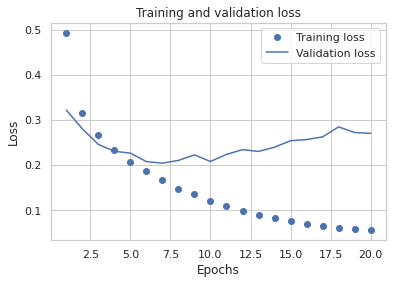

In [115]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

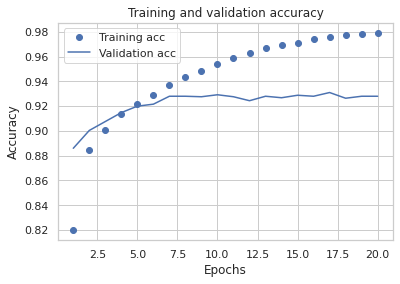

In [116]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 14
32 (3x3), 64 (5x5), pool


##Build and compile the model

In [0]:
# CNN with 2 convolution/max pooling layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# keras.utils.plot_model(model, show_shapes=True)

##Train the model

In [119]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 7s 122us/sample - loss: 0.4586 - accuracy: 0.8348 - val_loss: 0.2978 - val_accuracy: 0.8934
Epoch 2/20
55000/55000 [==============================] - 6s 115us/sample - loss: 0.2919 - accuracy: 0.8943 - val_loss: 0.2515 - val_accuracy: 0.9102
Epoch 3/20
55000/55000 [==============================] - 6s 114us/sample - loss: 0.2408 - accuracy: 0.9113 - val_loss: 0.2389 - val_accuracy: 0.9118
Epoch 4/20
55000/55000 [==============================] - 6s 114us/sample - loss: 0.2045 - accuracy: 0.9244 - val_loss: 0.2166 - val_accuracy: 0.9182
Epoch 5/20
55000/55000 [==============================] - 6s 114us/sample - loss: 0.1785 - accuracy: 0.9339 - val_loss: 0.2050 - val_accuracy: 0.9238
Epoch 6/20
55000/55000 [==============================] - 6s 115us/sample - loss: 0.1540 - accuracy: 0.9412 - val_loss: 0.2067 - val_accuracy: 0.9232
Epoch 7/20
55000/55000 [===========================

In [120]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

127.146923

## Test the model

In [121]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.35371681201979516, 0.9253)

In [122]:
test_time = test_rt.process_time
test_time # in seconds

0.589047

##Add training and test statistics to results dataframe

In [123]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.050527,0.981455,0.307340,0.9262
16,0.047124,0.982455,0.292114,0.9242
17,0.042043,0.985291,0.315916,0.9176
18,0.038856,0.985600,0.321544,0.9240
19,0.036320,0.987309,0.312200,0.9238


In [124]:
results_dfnew = history_df.iloc[-1:].copy()
results_dfnew.insert(0,'model','CNN (2 layers), 32-64-pool, 3x3, 5x5') # want the model name to appear first
results_dfnew['test_loss'] = test_loss #incorporate test results
results_dfnew['test_accuracy'] = test_acc
results_dfnew['training time (sec)'] = train_time     
results_dfnew['testing time (sec)'] = test_time      # testing time appears last
results_dfnew

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,"CNN (2 layers), 32-64-pool, 3x3, 5x5",0.03632,0.987309,0.3122,0.9238,0.353717,0.9253,127.146923,0.589047


In [125]:
results_df=results_df.append(results_dfnew,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,"CNN (2 layers), baseline 32pool64pool",0.148440,0.942564,0.229695,0.9206,0.240504,0.9187,68.169618,0.486633
1,"CNN (2 layers), 64pool32pool",0.165884,0.936509,0.212797,0.9248,0.237632,0.9165,71.097494,0.501577
2,"CNN (2 layers), 32-64-pool, 5x5, 3x3",0.056374,0.978818,0.288349,0.9252,0.309188,0.9230,113.877381,0.559199
3,"CNN (4 layers), 32-32pool-64-64pool",0.149929,0.943709,0.213560,0.9236,0.234258,0.9245,128.761204,0.582940
4,"CNN (2 layers), 64pool128pool",0.095781,0.962927,0.242315,0.9218,0.268553,0.9209,85.164486,0.565040
5,"CNN (4 layers), 64-64pool-128-128pool",0.110739,0.957727,0.194529,0.9342,0.243228,0.9265,226.995776,0.667235
6,"CNN (4 layers), 64-64pool-32-32-pool",0.190692,0.927491,0.196606,0.9240,0.223326,0.9191,197.533521,0.621062
7,"CNN (4 layers), 128-128pool-64-64pool",0.135746,0.948909,0.199482,0.9342,0.219884,0.9291,361.905492,0.780554
8,"CNN (2 layers), 32-64-pool, 5x5, 3x3",0.055121,0.979273,0.270570,0.9280,0.322072,0.9222,116.663987,0.565231
9,"CNN (2 layers), 32-64-pool, 3x3, 5x5",0.036320,0.987309,0.312200,0.9238,0.353717,0.9253,127.146923,0.589047


## Plotting the performance 

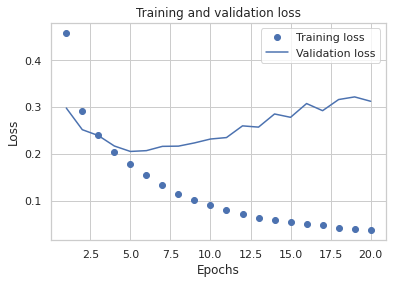

In [126]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

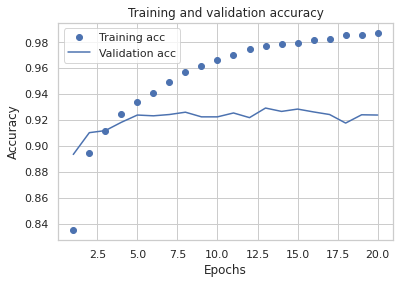

In [127]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Export final results

In [0]:
#Export results dataframe

from google.colab import files

results_df.to_csv('A2_3x3convNodes_line.csv')
files.download('A2_3x3convNodes_line.csv')